In [15]:
import numpy as np
from scipy.constants import e, m_p, m_e, c, epsilon_0, m_n, k as kb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle
import scipy.ndimage as snd

plt.rcParams.update({
    # Color cycle
    "axes.prop_cycle": cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']),

    # Figure size
    "figure.figsize": (4, 3),

    # X ticks
    "xtick.direction": "in",
    "xtick.major.size": 3,
    "xtick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.visible": True,
    "xtick.top": True,

    # Y ticks
    "ytick.direction": "in",
    "ytick.major.size": 3,
    "ytick.major.width": 0.5,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.visible": True,
    "ytick.right": True,

    # Axes & lines
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 1.0,

    # Font & math
    "font.family": "sans-serif",
    #"mathtext.fontset": "dejavuserif",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",

    # Legend & saving
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})


In [336]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2570 / Axis length                                    
NAXIS2  =                 4611 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2006-03-20T14:56:47' / Date FITS file was generated                  
IRAF-TLM= '14:56:45 (20/03/2006)' / Time of last modification                   
OBJECT  = 'Lockman_mosaic_r_1046+5902 - DelRA =   0.0, DelDec =   0.0' / Name of
NEXTEND =                   

In [16]:
%matplotlib widget

In [2]:
%matplotlib inline

# Preliminary

## Plot the original image 

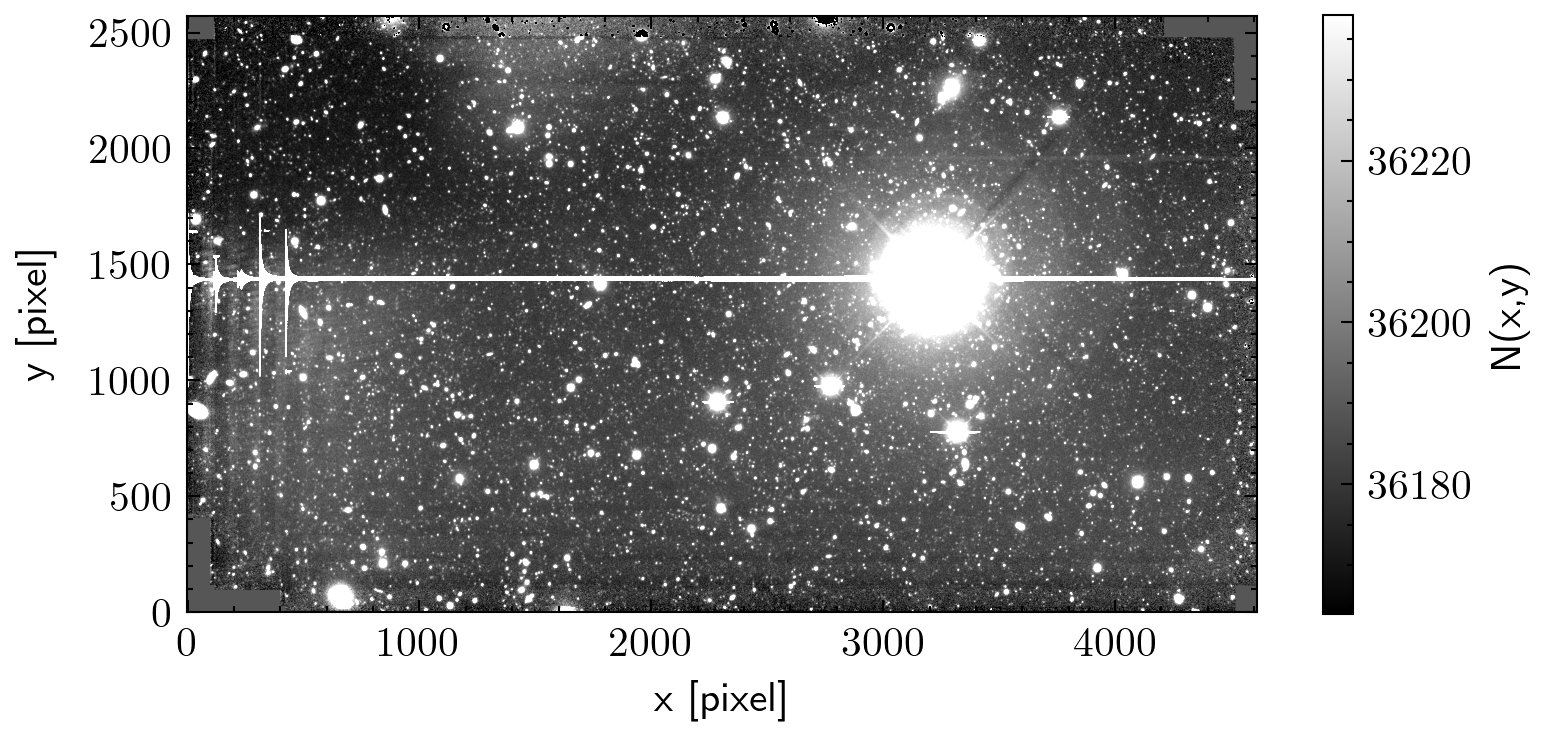

In [3]:
# Load the FITS file
with fits.open("data/Fits_Data/mosaic.fits") as hdul:
    image_data = hdul[0].data # this contains the count in each pixel
    header = hdul[0].header

# Apply scaling
# REAL = TAPE*BSCALE + BZERO                     
scaled_image = image_data.T * header.get('BSCALE', 1) + header.get('BZERO', 0)

# Get aspect ratio (width / height)
ny, nx = scaled_image.shape
aspect_ratio = nx / ny
enlarge = 1

# Plot
plt.figure(figsize=(3 * aspect_ratio * enlarge, 3 * enlarge), dpi=300)
plt.imshow(
    scaled_image,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95)
)
plt.title('')
plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

## Plot histogram for the original image (zoom into the Gaussian region)

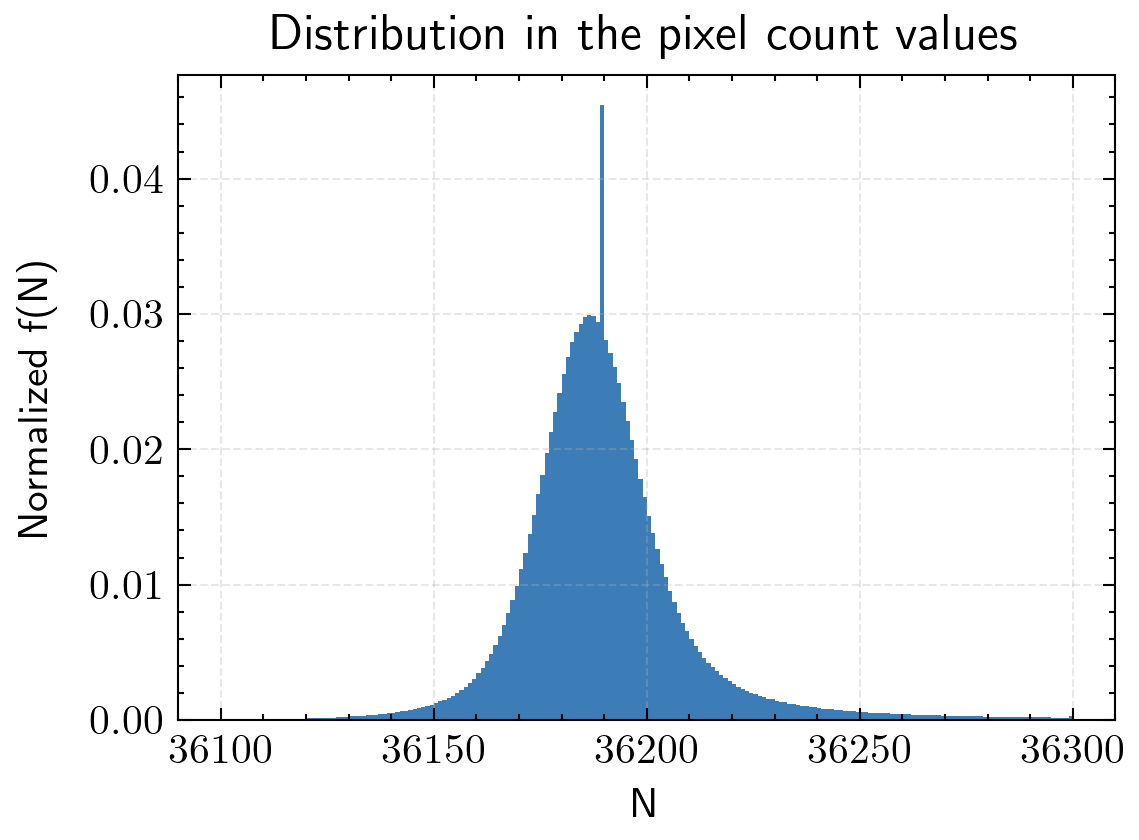

Mean: 36189.056
Std:  19.263


In [4]:
# Flatten to 1D array of counts
pixels = scaled_image.flatten()

# Define range
min_count, max_count = 36.1e3, 36.3e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Compute bins with width = 1
bin_edges = np.arange(min_count, max_count + 1, 1)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=bin_edges, alpha=0.8, density=True)
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")

# De-noising / cleaning

## Crop out the noisy part

Fraction of lost data: 0.1734871863679055


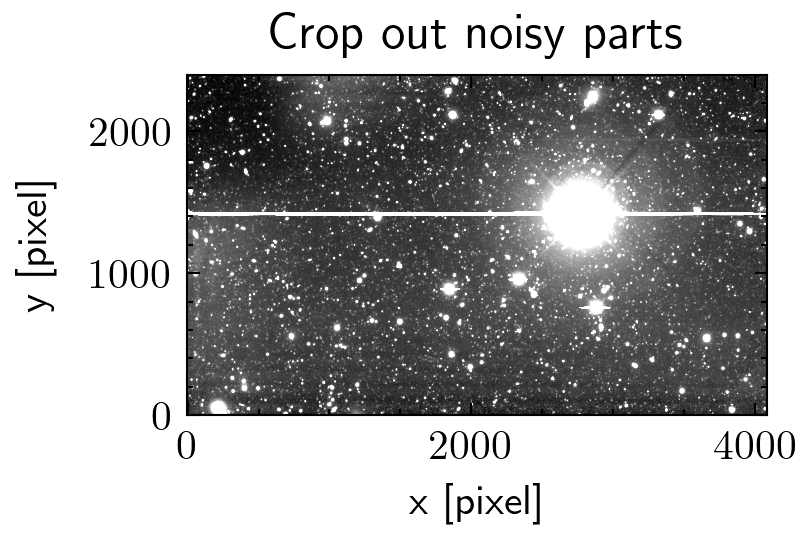

In [6]:
# Crop out the border part
crop = scaled_image[20:-150, 440:-90]
aspect_ratio_new = crop.shape[1] / crop.shape[0]

# Calculate percentage of data lost
print('Fraction of lost data:', 1 - crop.size / scaled_image.size)

# Plot again
plt.figure(figsize=(2 * aspect_ratio_new, 2), dpi=300)
plt.imshow(
    crop,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(crop, 5),
    vmax=np.percentile(crop, 95)
)

plt.title('Crop out noisy parts')
# plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()


In [18]:
# --- Define mask function ---
def mask_circle(mask, center, radius):
    x0, y0 = center
    yy, xx = np.ogrid[:mask.shape[0], :mask.shape[1]]
    circle_mask = (xx - x0)**2 + (yy - y0)**2 <= radius**2
    mask[circle_mask] = False
    return mask

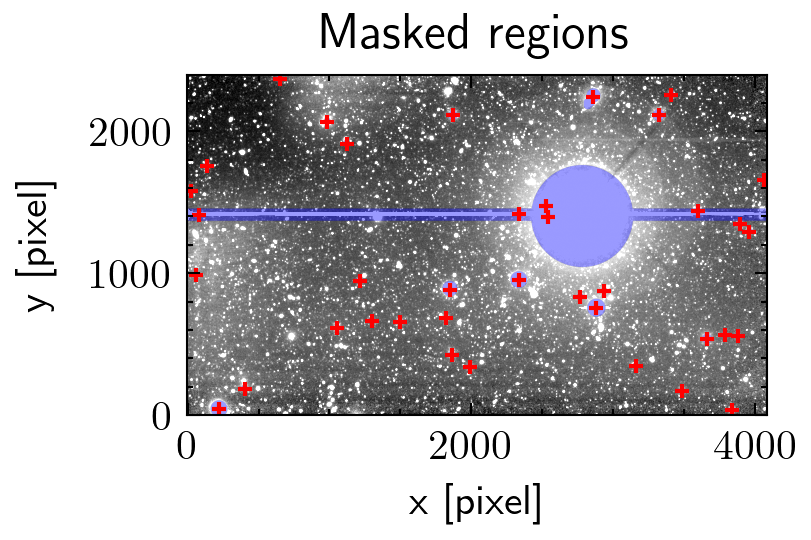

In [29]:
# --- Initialize mask array ---
mask_bool = np.ones_like(crop, dtype=bool)

# --- Apply manual masking ---
mask_bool[1366:1455, :] = False
mask_bool = mask_circle(mask_bool, center=(2780, 1400), radius=360)
mask_bool = mask_circle(mask_bool, center=(2880, 755), radius=65)
mask_bool = mask_circle(mask_bool, center=(1850, 890), radius=55)
mask_bool = mask_circle(mask_bool, center=(2335, 953), radius=60)
mask_bool = mask_circle(mask_bool, center=(3318, 2112), radius=42)
mask_bool = mask_circle(mask_bool, center=(3658, 538), radius=35)
mask_bool = mask_circle(mask_bool, center=(225, 44), radius=60)
mask_bool = mask_circle(mask_bool, center=(2860, 2250), radius=50)
mask_bool = mask_circle(mask_bool, center=(2820, 2180), radius=30)
mask_bool = mask_circle(mask_bool, center=(2820, 2200), radius=30)
mask_bool = mask_circle(mask_bool, center=(2840, 2200), radius=30)
mask_bool = mask_circle(mask_bool, center=(1870, 2110), radius=34)

# --- Detect remaining bright regions ---
bright_mask = crop > 5e4
labels, num = snd.label(bright_mask, structure=np.ones((3, 3)))
centers = snd.center_of_mass(crop, labels, np.arange(1, num + 1))
yy = [c[0] for c in centers]
xx = [c[1] for c in centers]

# --- Mask out small circular regions around detected centers ---
for x, y in zip(xx, yy):
    mask_bool = mask_circle(mask_bool, center=(x, y), radius=24)

# --- Visualize masked regions ---
plt.figure(figsize=(2 * aspect_ratio_new, 2), dpi=300)

# Base grayscale image
plt.imshow(crop, cmap='gray', origin='lower',
           vmin=np.percentile(crop[mask_bool], 5),
           vmax=np.percentile(crop[mask_bool], 95))


# Overlay blue for masked (False) areas
overlay = np.zeros((*mask_bool.shape, 4))  # RGBA
overlay[~mask_bool] = [0, 0, 1, 0.4]       # blue with alpha=0.4
plt.imshow(overlay, origin='lower')


plt.scatter(xx, yy, s=10, marker='+', c='red', linewidths=1)
plt.title('Masked regions')
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()


## Replot histogram

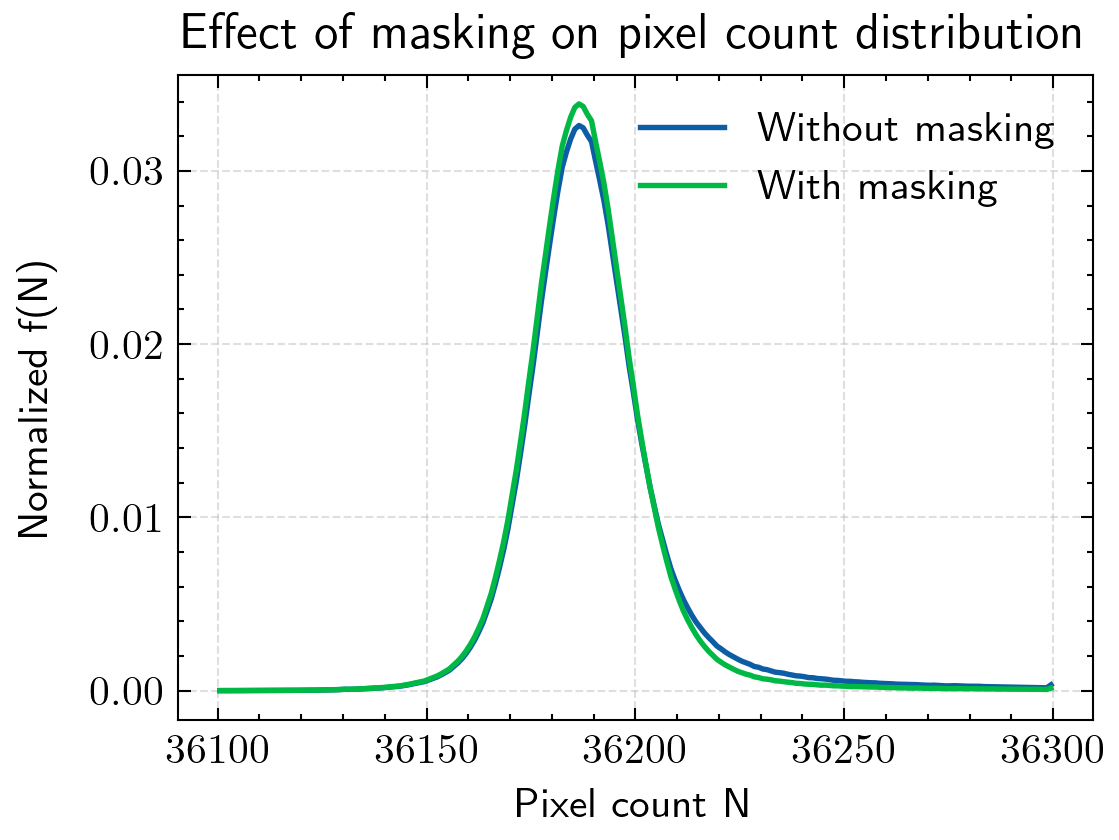

36187.89292894479


In [45]:
# --- Flatten both arrays ---
pixels_all = crop.flatten()
pixels_masked = crop[mask_bool].flatten()

# --- Define range and bins ---
min_count, max_count = 36.1e3, 36.3e3
bin_edges = np.arange(min_count, max_count + 1, 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Apply range selection ---
pixels_all_in_range = pixels_all[(pixels_all >= min_count) & (pixels_all <= max_count)]
pixels_masked_in_range = pixels_masked[(pixels_masked >= min_count) & (pixels_masked <= max_count)]

# --- Manual histogram (normalized) ---
hist_all, _ = np.histogram(pixels_all_in_range, bins=bin_edges, density=True)
hist_masked, _ = np.histogram(pixels_masked_in_range, bins=bin_edges, density=True)

# --- Plot as smooth line ---
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(bin_centers, hist_all, lw=1.3, label='Without masking')
plt.plot(bin_centers, hist_masked, lw=1.3, label='With masking')
plt.xlabel('Pixel count N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Effect of masking on pixel count distribution')
plt.legend()
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

# Object detection

In [ ]:
# Let's look at 0 to 500 for x and 0 to 500 for y of the crop version
# Loop to detect objects: 
# Keep finding the next brightest object until their count = background + threshold where threshold = 2 * std for now
# Then we form circle of initial radius 6 pixel around that particular point. Then we keep going out in +2 pixel in radius until count ---> background level (median) 

small_image = crop[0:400, 0:400]
small_mask = mask_bool[0:400, 0:400]

from matplotlib.patches import Circle

# --- Copy working image and mask ---
img = small_image.copy()
mask = small_mask.copy()

# --- Compute background stats ---
valid_pixels = img[mask]
median_val = np.median(valid_pixels)
std_val = np.std(valid_pixels)
threshold = median_val + 2 * std_val

print(f"Median: {median_val:.3f}, Std: {std_val:.3f}")

# --- Setup figure ---
fig, ax = plt.subplots(dpi=300)
ax.imshow(img, cmap='gray', origin='lower',
          vmin=np.percentile(valid_pixels, 5),
          vmax=np.percentile(valid_pixels, 95))
ax.set_title('Detection loop (expanding circles)')

# --- Loop detection ---
yy, xx = np.indices(img.shape)
detected = 0

while True:
    # Find brightest unmasked pixel
    masked_img = np.where(mask, img, -np.inf)
    y_peak, x_peak = np.unravel_index(np.argmax(masked_img), img.shape)
    peak_val = img[y_peak, x_peak]

    if peak_val < threshold:
        break  # stop when no bright pixels left

    # Expand radius
    radius = 6
    while True:
        circle_mask = (xx - x_peak)**2 + (yy - y_peak)**2 <= radius**2
        local_vals = img[circle_mask & mask]
        local_mean = np.mean(local_vals) if local_vals.size > 0 else 0
        if local_mean <= median_val:
            break
        radius += 2

    # Draw circle on plot
    circ = Circle((x_peak, y_peak), radius, edgecolor='red',
                  facecolor='none', lw=0.8)
    ax.add_patch(circ)

    # Mark area as used
    mask[circle_mask] = False
    detected += 1

print(f"Detected {detected} bright regions.")

plt.tight_layout()
plt.show()


Median: 36190.000, Std: 38.539
